# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('D:/Work/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
#final['Score'].value_counts()

#sampling 100k points
pos = final[final['Score']==1].sample(n = 50000)
neg = final[final['Score']==0].sample(n = 50000)
final_ = pd.concat([pos,neg])
print("Sampled data: ", final_.shape)

#sampling 40k points for rbf kernel
pos_ = final[final['Score']==1].sample(n=20000)
neg_ = final[final['Score']==0].sample(n=20000)
final_rbf = pd.concat([pos_,neg_])
print("Data for rbf kernel: ", final_rbf.shape)

(364171, 10)
Sampled data:  (100000, 10)
Data for rbf kernel:  (40000, 10)


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final_['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final_['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final_['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final_['Text'].values[4900]
print(sent_4900)
print("="*50)

Mostly these days I find companies that are liviing in a dream state.  Davidson Tea is obviously, to me, one of the few that does not fall into this catagory.  Their product is the best I have had and their presentation and dellivery are the same.  I mean<br />top end Hibiscus.  Thanks for the service,  Joe
Great tasting chocolate cookies with a nice fudge center. These cookies are great for a chocolate lover and anyone who loves a super moist cookie because they are soft and moist. I love the consistency and the taste of these cookies. I will buy the cookies again.<br /><br />These cookies are similar to what a gourmet bakery will offer with out the overpricing of the bakery. I wish they were a little firmer so that when I microwave them they don't fall apart. The reseal able packaging is perfect to keep your cookies nice and fresh without worrying about them getting stale or attracting any insects. Great Job Chips Ahoy with this new Megafudge line of cookies my son and I loved them.


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Mostly these days I find companies that are liviing in a dream state.  Davidson Tea is obviously, to me, one of the few that does not fall into this catagory.  Their product is the best I have had and their presentation and dellivery are the same.  I mean<br />top end Hibiscus.  Thanks for the service,  Joe


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Mostly these days I find companies that are liviing in a dream state.  Davidson Tea is obviously, to me, one of the few that does not fall into this catagory.  Their product is the best I have had and their presentation and dellivery are the same.  I meantop end Hibiscus.  Thanks for the service,  Joe
Great tasting chocolate cookies with a nice fudge center. These cookies are great for a chocolate lover and anyone who loves a super moist cookie because they are soft and moist. I love the consistency and the taste of these cookies. I will buy the cookies again.These cookies are similar to what a gourmet bakery will offer with out the overpricing of the bakery. I wish they were a little firmer so that when I microwave them they don't fall apart. The reseal able packaging is perfect to keep your cookies nice and fresh without worrying about them getting stale or attracting any insects. Great Job Chips Ahoy with this new Megafudge line of cookies my son and I loved them.
I live in the boon

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I live in the boonies in Texas and when the local Wal-Mart stopped carrying Wiley is I thought the world was coming to an end!  I LOVE LOVE LOVE this product and now that I can order it online, I am once again a happy camper.  This is the BEST product to season purple hulls peas and others just like my grandmas did in the boonies of Arkansas (only there is no bacon grease!).  YUM!


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Mostly these days I find companies that are liviing in a dream state.  Davidson Tea is obviously, to me, one of the few that does not fall into this catagory.  Their product is the best I have had and their presentation and dellivery are the same.  I mean<br />top end Hibiscus.  Thanks for the service,  Joe


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I live in the boonies in Texas and when the local Wal Mart stopped carrying Wiley is I thought the world was coming to an end I LOVE LOVE LOVE this product and now that I can order it online I am once again a happy camper This is the BEST product to season purple hulls peas and others just like my grandmas did in the boonies of Arkansas only there is no bacon grease YUM 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final_['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    
preprocessed_reviews_rbf = []
# tqdm is for printing the status bar
for sentance in tqdm(final_rbf['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_rbf.append(sentance.strip())    

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [00:43<00:00, 909.33it/s]


In [23]:
preprocessed_reviews[1500]

'live boonies texas local wal mart stopped carrying wiley thought world coming end love love love product order online happy camper best product season purple hulls peas others like grandmas boonies arkansas no bacon grease yum'

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(preprocessed_reviews, final_['Score'], test_size=0.3)

X_train_rbf, X_test_rbf, Y_train_rbf, Y_test_rbf = train_test_split(preprocessed_reviews_rbf, final_rbf['Score'], test_size=0.3)

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer(min_df=10, max_features=5000) #in scikit-learn
X_train_bow = count_vect.fit_transform(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
X_test_bow = count_vect.transform(X_test)
final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


#BoW
count_vect_rbf = CountVectorizer(min_df=10, max_features=500)
X_train_bow_rbf = count_vect_rbf.fit_transform(X_train_rbf)
print("some feature names ", count_vect_rbf.get_feature_names()[:10])
print('='*50)
X_test_bow_rbf = count_vect_rbf.transform(X_test_rbf)
final_counts_rbf = count_vect_rbf.transform(preprocessed_reviews_rbf)
print("the type of count vectorizer ",type(final_counts_rbf))
print("the shape of out text BOW vectorizer ",final_counts_rbf.get_shape())
print("the number of unique words ", final_counts_rbf.get_shape()[1])

some feature names  ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'acai', 'accept', 'acceptable', 'accepted']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (100000, 5000)
the number of unique words  5000
some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'already', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (40000, 500)
the number of unique words  500


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (100000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [90]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_train_tfidf = tf_idf_vect.fit_transform(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_test_tfidf = tf_idf_vect.transform(X_test)
final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])


tf_idf_vect_rbf = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
X_train_tfidf_rbf = tf_idf_vect_rbf.fit_transform(X_train_rbf)
print("some sample features(unique words in the corpus)",tf_idf_vect_rbf.get_feature_names()[0:10])
print('='*50)

X_test_tfidf_rbf = tf_idf_vect_rbf.transform(X_test_rbf)
final_tf_idf_rbf = tf_idf_vect_rbf.transform(preprocessed_reviews_rbf)
print("the type of count vectorizer ",type(final_tf_idf_rbf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_rbf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_rbf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdominal', 'ability', 'able', 'able buy']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (100000, 41671)
the number of unique words including both unigrams and bigrams  41671
some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'already', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (40000, 500)
the number of unique words including both unigrams and bigrams  500


## [4.4] Word2Vec

In [91]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance = []
for sentance in X_train:
    list_of_sentance.append(sentance.split())
    
list_of_sent_test = []
for sentance in X_test:
    list_of_sent_test.append(sentance.split())
    
list_of_sentance_rbf = []
for sentance in X_train_rbf:
    list_of_sentance_rbf.append(sentance.split())
    
list_of_sent_test_rbf = []
for sentance in X_test_rbf:
    list_of_sent_test_rbf.append(sentance.split())    

In [92]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8507898449897766), ('fantastic', 0.8502188920974731), ('good', 0.8171984553337097), ('wonderful', 0.8091678023338318), ('excellent', 0.8001160621643066), ('perfect', 0.7954995632171631), ('terrific', 0.788025975227356), ('amazing', 0.7688205242156982), ('fabulous', 0.7170669436454773), ('nice', 0.7040174603462219)]
[('nastiest', 0.8667160272598267), ('greatest', 0.7625442743301392), ('best', 0.7607357501983643), ('vile', 0.656509280204773), ('tastiest', 0.6369719505310059), ('saltiest', 0.6305539608001709), ('disgusting', 0.607917070388794), ('grossest', 0.6060681343078613), ('worse', 0.595989465713501), ('awful', 0.5902849435806274)]


In [93]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  16659
sample words  ['excellent', 'variety', 'quantity', 'gift', 'coffee', 'lover', 'friend', 'mine', 'also', 'pleased', 'recieve', 'quality', 'product', 'dog', 'got', 'ill', 'eating', 'treats', 'e', 'g', 'diarrhea', 'vomiting', 'would', 'not', 'recommend', 'pet', 'owner', 'agree', 'folks', 'concerned', 'made', 'china', 'aspect', 'packaging', 'makes', 'appealing', 'natural', 'healthy', 'treat', 'dogs', 'purchase', 'caution', 'pot', 'lids', 'standardized', 'supplier', 'quite', 'helpful', 'first', 'lid']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [94]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_TRAIN_aw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_TRAIN_aw2v.append(sent_vec)
print(len(sent_vectors_TRAIN_aw2v))
print(len(sent_vectors_TRAIN_aw2v[0]))
    
    
sent_vectors_TEST_aw2v = []; 
for sent in tqdm(list_of_sent_test): 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_TEST_aw2v.append(sent_vec)    

print(len(sent_vectors_TEST_aw2v))
print(len(sent_vectors_TEST_aw2v[0]))


# average Word2Vec
# compute average word2vec for each review.
sent_vectors_TRAIN_rbf_aw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_rbf): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_TRAIN_rbf_aw2v.append(sent_vec)
print(len(sent_vectors_TRAIN_rbf_aw2v))
print(len(sent_vectors_TRAIN_rbf_aw2v[0]))
    
    
sent_vectors_TEST_rbf_aw2v = []; 
for sent in tqdm(list_of_sent_test_rbf): 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_TEST_rbf_aw2v.append(sent_vec)    

print(len(sent_vectors_TEST_rbf_aw2v))
print(len(sent_vectors_TEST_rbf_aw2v[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [01:24<00:00, 831.34it/s]


70000
50


100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:39<00:00, 755.54it/s]


30000
50


100%|███████████████████████████████████████████████████████████████████████████| 28000/28000 [00:36<00:00, 760.80it/s]


28000
50


100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [00:15<00:00, 778.35it/s]


12000
50


#### [4.4.1.2] TFIDF weighted W2v

In [95]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(max_features=500)
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary1 = dict(zip(model.get_feature_names(), list(model.idf_)))

model2 = TfidfVectorizer(max_features=500)
tf_idf_matrix_2 = model2.fit_transform(preprocessed_reviews_rbf)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary2 = dict(zip(model2.get_feature_names(), list(model2.idf_)))

In [96]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_TRAIN_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary1[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_TRAIN_tfidfw2v.append(sent_vec)
    row += 1
    
tfidf_sent_vectors_TEST_tfidfw2v = [];
row=0
for sent in tqdm(list_of_sent_test):  
    sent_vec = np.zeros(50) 
    weight_sum =0
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary1[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_TEST_tfidfw2v.append(sent_vec)
    row += 1
    
# TF-IDF weighted Word2Vec
tfidf_feat = model2.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_TRAIN_rbf_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_rbf): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary2[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_TRAIN_rbf_tfidfw2v.append(sent_vec)
    row += 1
    
tfidf_sent_vectors_TEST_rbf_tfidfw2v = [];
row=0
for sent in tqdm(list_of_sent_test_rbf):  
    sent_vec = np.zeros(50) 
    weight_sum =0
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary2[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_TEST_rbf_tfidfw2v.append(sent_vec)
    row += 1            

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [00:17<00:00, 671.49it/s]


# SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>Use of SGDClassifier’ with hinge loss because it is computationally less expensive and works like linear SVM</li>
    <li>Similarly, like kdtree of knn, while working with RBF kernel it's better to reduce the number of dimensions. min_df = 10, max_features = 500. 40k points considered.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (Best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Finding the best hyper paramter using 3-fold cross validation.</li>
    <li>Used gridsearch cv for hyper parameter tuning in the case of RBF kernel SVM.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>While working on the linear kernel with BOW or TFIDF top 10 best features are printed for each of the positive and negative classes.</li>
        </ul>
    </li>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [124]:
# standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(copy=True, with_mean=False, with_std=True)
X_tra = std.fit_transform(X_train_bow)
X_tes = std.transform(X_test_bow)


from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000]
pen =  ['l2','l1']
d = {}

for i in alpha:
    for j in pen:                         
        clf = SGDClassifier(alpha=i, penalty=j, loss='hinge', random_state=10)
        clf.fit(X_tra, Y_train)
        cccv = CalibratedClassifierCV(clf, method="sigmoid")
        cccv.fit(X_tra, Y_train)
        predict_y = cccv.predict_proba(X_tes)[:,1]
        temp = roc_auc_score(Y_test, predict_y)
        d[i,j] = (temp)   

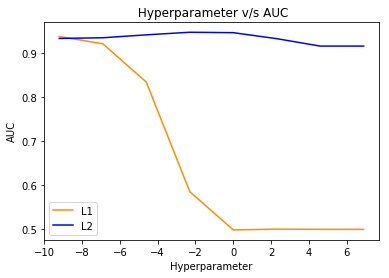

In [125]:
l1 = []
l2 = []
for i in alpha:
    l1.append(d[i,'l1'])
    l2.append(d[i,'l2'])

plt.plot(np.log(alpha),l1, color = 'darkorange', label='L1')
plt.plot(np.log(alpha),l2, color = 'blue', label='L2')
plt.legend()
plt.xlabel('Hyperparameter')
plt.ylabel('AUC')
plt.title(' Hyperparameter v/s AUC')
plt.show()

In [126]:
import operator
c_ = max(d.items(), key=operator.itemgetter(1))[0]
max_auc = d[c_]
print('The best value of hyper parameter is ', c_)
print('The max auc score is ', max_auc)

The best value of hyper parameter is  (0.1, 'l2')
The max auc score is  0.9469278064


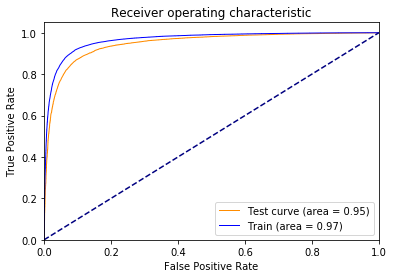

Accuracy on test set: 0.89%
Precision on test set: 0.88%
Recall on test set: 0.89%
F1 score on test set: 0.89%


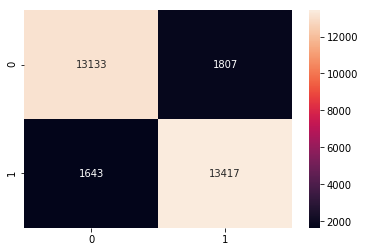

In [127]:
#training the model with best value of hyper parameter
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc

clf = SGDClassifier(alpha=c_[0], penalty=c_[1], loss='hinge', random_state=10)
clf.fit(X_tra, Y_train)
cccv = CalibratedClassifierCV(clf, method="sigmoid")
cccv.fit(X_tra, Y_train)

predict_y_tr = cccv.predict_proba(X_tra)
predict_y = cccv.predict_proba(X_tes)
y_pred  = cccv.predict(X_tes)

fpr, tpr, thresholds = roc_curve(Y_test, predict_y[:,1])
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train, predict_y_tr[:,1])

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

import seaborn as sns
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True, fmt='d')

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pred)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pred)))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pred)))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pred)))

In [128]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						Positive
________________________________________________________________________________________________
	-0.2678	not            				0.2267	great          
	-0.1478	disappointed   				0.1686	best           
	-0.1062	worst          				0.1568	good           
	-0.1014	terrible       				0.1484	love           
	-0.0984	awful          				0.1447	delicious      
	-0.0919	disappointing  				0.1227	loves          
	-0.0909	stale          				0.1066	perfect        
	-0.0861	horrible       				0.1023	excellent      
	-0.0860	thought        				0.0962	nice           
	-0.0840	disappointment 				0.0932	wonderful      


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [97]:
# standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(copy=True, with_mean=False, with_std=True)
X_tra = std.fit_transform(X_train_tfidf)
X_tes = std.transform(X_test_tfidf)


from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import hinge_loss
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000]
pen =  ['l2','l1']
d = {}

for i in alpha:
    for j in pen:                         
        clf = SGDClassifier(alpha=i, penalty=j, loss='hinge', random_state=10, class_weight='balanced')
        clf.fit(X_tra, Y_train)
        cccv = CalibratedClassifierCV(clf, cv=10, method="sigmoid")
        cccv.fit(X_tra, Y_train)
        predict_y = cccv.predict_proba(X_tes)[:,1]
        temp = roc_auc_score(Y_test,predict_y)
        d[i,j] = (temp)   

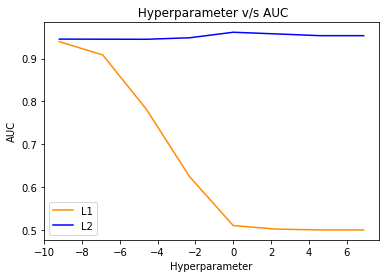

In [98]:
l1 = []
l2 = []
for i in alpha:
    l1.append(d[i,'l1'])
    l2.append(d[i,'l2'])

plt.plot(np.log(alpha),l1, color = 'darkorange', label='L1')
plt.plot(np.log(alpha),l2, color = 'blue', label='L2')
plt.legend()
plt.xlabel('Hyperparameter')
plt.ylabel('AUC')
plt.title(' Hyperparameter v/s AUC')
plt.show()

In [100]:
import operator
c_ = max(d.items(), key=operator.itemgetter(1))[0]
max_auc = d[c_]
print('The best value of hyper parameter is ', c_)
print('The max auc score ', max_auc)

The best value of hyper parameter is  (1, 'l2')
The max auc score  0.96157645189


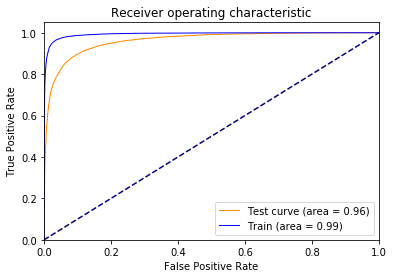

Accuracy on test set: 0.90%
Precision on test set: 0.90%
Recall on test set: 0.90%
F1 score on test set: 0.90%


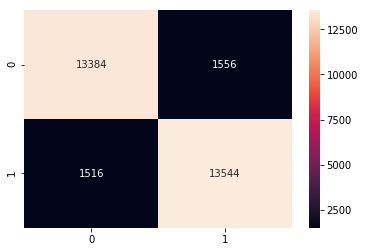

In [101]:
#training the model with best value of hyper parameter
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc

clf = SGDClassifier(alpha=c_[0], penalty=c_[1], loss='hinge', random_state=10)
clf.fit(X_tra, Y_train)
cccv = CalibratedClassifierCV(clf, method="sigmoid")
cccv.fit(X_tra, Y_train)

predict_y_tr = cccv.predict_proba(X_tra)[:,1]
predict_y = cccv.predict_proba(X_tes)[:,1]
y_pred  = cccv.predict(X_tes)

fpr, tpr, thresholds = roc_curve(Y_test, predict_y)
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train, predict_y_tr)

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

import seaborn as sns
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True, fmt='d')

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pred)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pred)))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pred)))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pred)))

In [103]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tf_idf_vect,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						Positive
________________________________________________________________________________________________
	-0.0518	not            				0.0526	great          
	-0.0390	disappointed   				0.0398	best           
	-0.0309	not good       				0.0387	delicious      
	-0.0275	not buy        				0.0377	love           
	-0.0269	worst          				0.0333	good           
	-0.0259	disappointing  				0.0302	loves          
	-0.0259	not recommend  				0.0294	perfect        
	-0.0256	not worth      				0.0263	excellent      
	-0.0238	awful          				0.0261	wonderful      
	-0.0236	terrible       				0.0244	favorite       


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [104]:
# standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(copy=True, with_mean=False, with_std=True)
X_tra = std.fit_transform(sent_vectors_TRAIN_aw2v)
X_tes = std.transform(sent_vectors_TEST_aw2v)


from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import hinge_loss
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000]
pen =  ['l2','l1']
d = {}

for i in alpha:
    for j in pen:                         
        clf = SGDClassifier(alpha=i, penalty=j, loss='hinge', random_state=10, class_weight='balanced')
        clf.fit(X_tra, Y_train)
        cccv = CalibratedClassifierCV(clf, cv=10, method="sigmoid")
        cccv.fit(X_tra, Y_train)
        predict_y = cccv.predict_proba(X_tes)[:,1]
        temp = roc_auc_score(Y_test,predict_y)
        d[i,j] = (temp)   

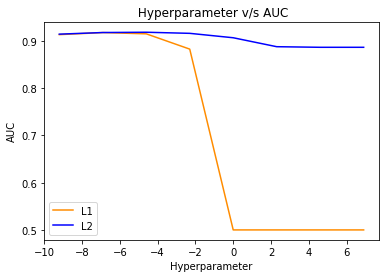

In [105]:
l1 = []
l2 = []
for i in alpha:
    l1.append(d[i,'l1'])
    l2.append(d[i,'l2'])

plt.plot(np.log(alpha),l1, color = 'darkorange', label='L1')
plt.plot(np.log(alpha),l2, color = 'blue', label='L2')
plt.legend()
plt.xlabel('Hyperparameter')
plt.ylabel('AUC')
plt.title(' Hyperparameter v/s AUC')
plt.show()

In [106]:
import operator
c_ = max(d.items(), key=operator.itemgetter(1))[0]
max_auc = d[c_]
print('The best value of hyper parameter is ', c_)
print('The max auc score ', max_auc)

The best value of hyper parameter is  (0.01, 'l2')
The max auc score  0.918579601718


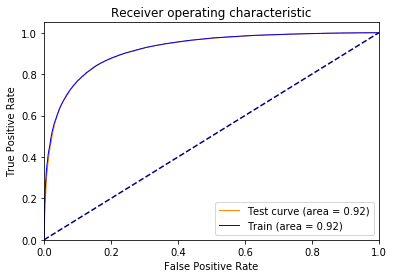

Accuracy on test set: 0.84%
Precision on test set: 0.85%
Recall on test set: 0.84%
F1 score on test set: 0.84%


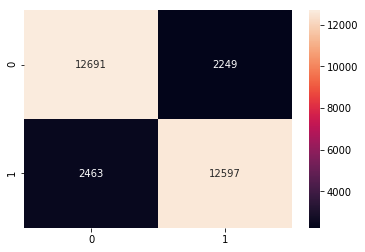

In [107]:
#training the model with best value of hyper parameter
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc

clf = SGDClassifier(alpha=c_[0], penalty=c_[1], loss='hinge', random_state=10)
clf.fit(X_tra, Y_train)
cccv = CalibratedClassifierCV(clf, method="sigmoid")
cccv.fit(X_tra, Y_train)

predict_y_tr = cccv.predict_proba(X_tra)[:,1]
predict_y = cccv.predict_proba(X_tes)[:,1]
y_pred  = cccv.predict(X_tes)

fpr, tpr, thresholds = roc_curve(Y_test, predict_y)
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train, predict_y_tr)

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

import seaborn as sns
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True, fmt='d')

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pred)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pred)))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pred)))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pred)))

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [108]:
# standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(copy=True, with_mean=False, with_std=True)
X_tra = std.fit_transform(tfidf_sent_vectors_TRAIN_tfidfw2v)
X_tes = std.transform(tfidf_sent_vectors_TEST_tfidfw2v)


from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import hinge_loss
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000]
pen =  ['l2','l1']
d = {}

for i in alpha:
    for j in pen:                         
        clf = SGDClassifier(alpha=i, penalty=j, loss='hinge', random_state=10, class_weight='balanced')
        clf.fit(X_tra, Y_train)
        cccv = CalibratedClassifierCV(clf, cv=10, method="sigmoid")
        cccv.fit(X_tra, Y_train)
        predict_y = cccv.predict_proba(X_tes)[:,1]
        temp = roc_auc_score(Y_test,predict_y)
        d[i,j] = (temp)   

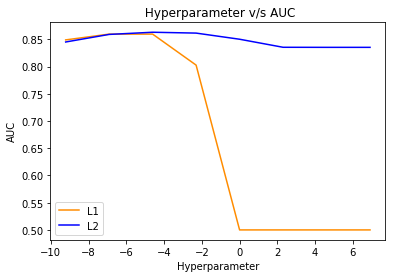

In [109]:
l1 = []
l2 = []
for i in alpha:
    l1.append(d[i,'l1'])
    l2.append(d[i,'l2'])

plt.plot(np.log(alpha),l1, color = 'darkorange', label='L1')
plt.plot(np.log(alpha),l2, color = 'blue', label='L2')
plt.legend()
plt.xlabel('Hyperparameter')
plt.ylabel('AUC')
plt.title(' Hyperparameter v/s AUC')
plt.show()

In [110]:
import operator
c_ = max(d.items(), key=operator.itemgetter(1))[0]
max_auc = d[c_]
print('The best value of hyper parameter is ', c_)
print('The max auc score ', max_auc)

The best value of hyper parameter is  (0.01, 'l2')
The max auc score  0.862938247012


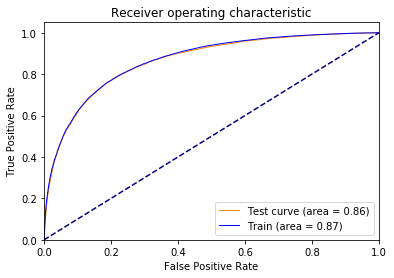

Accuracy on test set: 0.79%
Precision on test set: 0.79%
Recall on test set: 0.77%
F1 score on test set: 0.78%


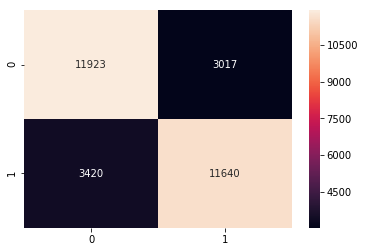

In [111]:
#training the model with best value of hyper parameter
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc

clf = SGDClassifier(alpha=c_[0], penalty=c_[1], loss='hinge', random_state=10)
clf.fit(X_tra, Y_train)
cccv = CalibratedClassifierCV(clf, method="sigmoid")
cccv.fit(X_tra, Y_train)

predict_y_tr = cccv.predict_proba(X_tra)[:,1]
predict_y = cccv.predict_proba(X_tes)[:,1]
y_pred  = cccv.predict(X_tes)

fpr, tpr, thresholds = roc_curve(Y_test, predict_y)
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train, predict_y_tr)

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

import seaborn as sns
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True, fmt='d')

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pred)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pred)))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pred)))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pred)))

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, make_scorer

def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1])    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)


clf = SVC(kernel='rbf', probability=True)
param_grid = {'C':[0.001,0.01,0.1,1,10,100,1000]} #params
gsv = GridSearchCV(clf,param_grid,verbose=1,scoring=auc_)
gsv.fit(X_train_bow_rbf,Y_train_rbf)
print("Best HyperParameter: ",gsv.best_params_)
print("Best AUC score: ", gsv.best_score_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 238.8min finished


Best HyperParameter:  {'C': 100}
Best AUC score:  0.909849473538


C:\Users\chauh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


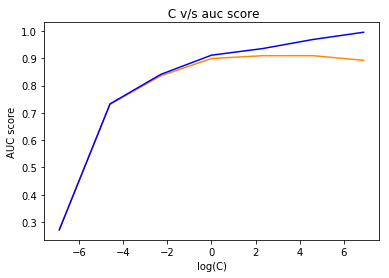

In [49]:
x = []
y = []
c = gsv.best_params_['C']

for i in gsv.grid_scores_:
    x.append(i[0]['C'])
    
y_test = gsv.cv_results_['mean_test_score']
y_train = gsv.cv_results_['mean_train_score']

plt.xlabel('log(C)')
plt.ylabel('AUC score')
plt.plot(np.log(x),y_test, color = 'darkorange')
plt.plot(np.log(x),y_train, color = 'blue')
plt.legend()
plt.title(' C v/s auc score')
plt.show()

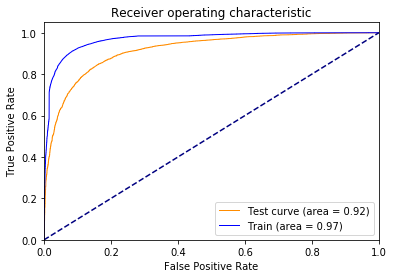

Accuracy on test set: 0.84%
Precision on test set: 0.85%
Recall on test set: 0.83%
F1 score on test set: 0.84%


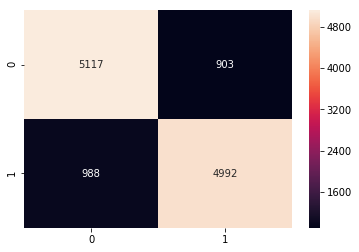

In [55]:
clf = SVC(C=c, probability=True)
clf.fit(X_train_bow_rbf,Y_train_rbf)
y_pred = clf.predict_proba(X_test_bow_rbf)
y_pred_tr = clf.predict_proba(X_train_bow_rbf)
y_pr = clf.predict(X_test_bow_rbf)

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

fpr, tpr, thresholds = roc_curve(Y_test_rbf, y_pred[:,1])
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train_rbf, y_pred_tr[:,1])

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test_rbf, y_pr)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test_rbf, y_pr)))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test_rbf, y_pr)))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test_rbf, y_pr)))
ax = sns.heatmap(confusion_matrix(Y_test_rbf, y_pr), annot=True, fmt='d')

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, make_scorer

def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1])    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)


clf = SVC(kernel='rbf', probability=True)
param_grid = {'C':[0.001,0.01,0.1,1,10,100,1000]} #params
gsv = GridSearchCV(clf,param_grid,verbose=1,scoring=auc_)
gsv.fit(X_train_tfidf_rbf,Y_train_rbf)
print("Best HyperParameter: ",gsv.best_params_)
print("Best AUC score: ", gsv.best_score_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 105.0min finished


Best HyperParameter:  {'C': 1000}
Best AUC score:  0.91609480409


C:\Users\chauh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


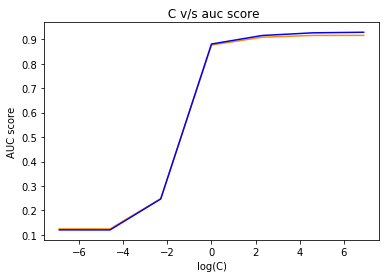

In [57]:
x = []
y = []
c = gsv.best_params_['C']

for i in gsv.grid_scores_:
    x.append(i[0]['C'])
    
y_test = gsv.cv_results_['mean_test_score']
y_train = gsv.cv_results_['mean_train_score']

plt.xlabel('log(C)')
plt.ylabel('AUC score')
plt.plot(np.log(x),y_test, color = 'darkorange')
plt.plot(np.log(x),y_train, color = 'blue')
plt.legend()
plt.title(' C v/s auc score')
plt.show()

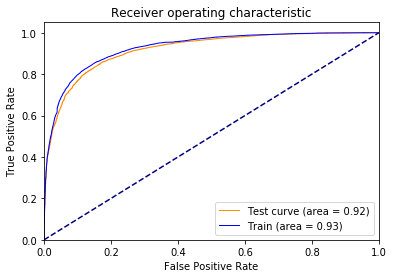

Accuracy on test set: 0.84%
Precision on test set: 0.85%
Recall on test set: 0.83%
F1 score on test set: 0.84%


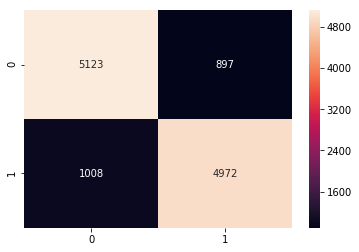

In [61]:
clf = SVC(C=c, probability=True)
clf.fit(X_train_tfidf_rbf,Y_train_rbf)
y_pred = clf.predict_proba(X_test_tfidf_rbf)
y_pred_tr = clf.predict_proba(X_train_tfidf_rbf)
y_pr = clf.predict(X_test_tfidf_rbf)


from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

fpr, tpr, thresholds = roc_curve(Y_test_rbf, y_pred[:,1])
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train_rbf, y_pred_tr[:,1])

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test_rbf, y_pr)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test_rbf, y_pr)))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test_rbf, y_pr)))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test_rbf, y_pr)))
ax = sns.heatmap(confusion_matrix(Y_test_rbf, y_pr), annot=True, fmt='d')

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, make_scorer

def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1])    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)


clf = SVC(kernel='rbf', probability=True)
param_grid = {'C':[0.001,0.01,0.1,1,10,100,1000]} #params
gsv = GridSearchCV(clf,param_grid,verbose=1,scoring=auc_)
gsv.fit(sent_vectors_TRAIN_rbf_aw2v,Y_train_rbf)
print("Best HyperParameter: ",gsv.best_params_)
print("Best AUC score: ", gsv.best_score_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 146.5min finished


Best HyperParameter:  {'C': 10}
Best AUC score:  0.926609631395


C:\Users\chauh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


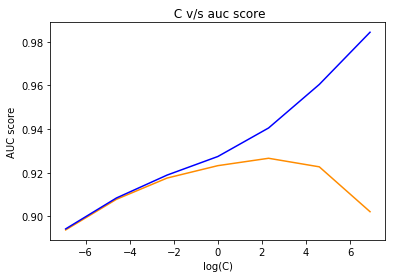

In [63]:
x = []
y = []
c = gsv.best_params_['C']

for i in gsv.grid_scores_:
    x.append(i[0]['C'])
    
y_test = gsv.cv_results_['mean_test_score']
y_train = gsv.cv_results_['mean_train_score']

plt.xlabel('log(C)')
plt.ylabel('AUC score')
plt.plot(np.log(x),y_test, color = 'darkorange')
plt.plot(np.log(x),y_train, color = 'blue')
plt.legend()
plt.title(' C v/s auc score')
plt.show()

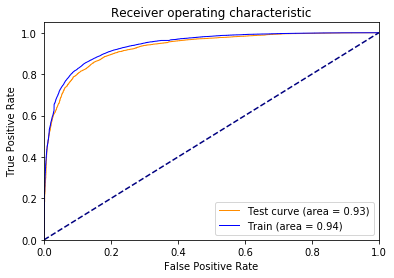

Accuracy on test set: 0.85%
Precision on test set: 0.86%
Recall on test set: 0.85%
F1 score on test set: 0.85%


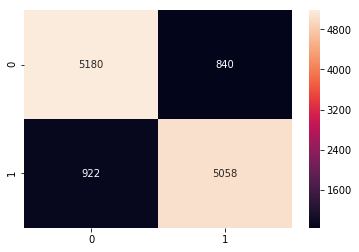

In [65]:
clf = SVC(C=c, probability=True)
clf.fit(sent_vectors_TRAIN_rbf_aw2v,Y_train_rbf)
y_pred = clf.predict_proba(sent_vectors_TEST_rbf_aw2v)
y_pred_tr = clf.predict_proba(sent_vectors_TRAIN_rbf_aw2v)
y_pr = clf.predict(sent_vectors_TEST_rbf_aw2v)


from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

fpr, tpr, thresholds = roc_curve(Y_test_rbf, y_pred[:,1])
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train_rbf, y_pred_tr[:,1])

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test_rbf, y_pr)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test_rbf, y_pr)))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test_rbf, y_pr)))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test_rbf, y_pr)))
ax = sns.heatmap(confusion_matrix(Y_test_rbf, y_pr), annot=True, fmt='d')

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, make_scorer

def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1])    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)


clf = SVC(kernel='rbf', probability=True)
param_grid = {'C':[0.001,0.01,0.1,1,10,100,1000]} #params
gsv = GridSearchCV(clf,param_grid,verbose=1,scoring=auc_)
gsv.fit(tfidf_sent_vectors_TRAIN_rbf_tfidfw2v,Y_train_rbf)
print("Best HyperParameter: ",gsv.best_params_)
print("Best AUC score: ", gsv.best_score_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 240.6min finished


Best HyperParameter:  {'C': 1}
Best AUC score:  0.88031455414


C:\Users\chauh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


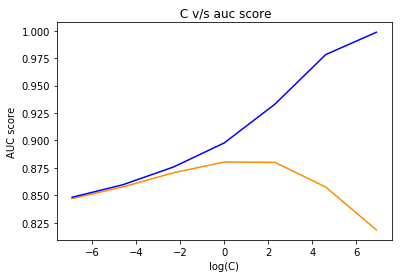

In [68]:
x = []
y = []
c = gsv.best_params_['C']

for i in gsv.grid_scores_:
    x.append(i[0]['C'])
    
y_test = gsv.cv_results_['mean_test_score']
y_train = gsv.cv_results_['mean_train_score']

plt.xlabel('log(C)')
plt.ylabel('AUC score')
plt.plot(np.log(x),y_test, color = 'darkorange')
plt.plot(np.log(x),y_train, color = 'blue')
plt.legend()
plt.title(' C v/s auc score')
plt.show()

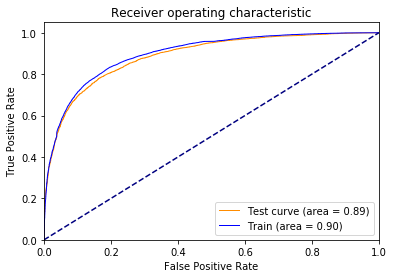

Accuracy on test set: 0.81%
Precision on test set: 0.81%
Recall on test set: 0.79%
F1 score on test set: 0.80%


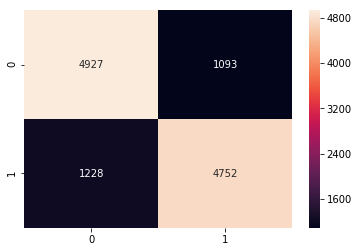

In [70]:
clf = SVC(C=c, probability=True)
clf.fit(tfidf_sent_vectors_TRAIN_rbf_tfidfw2v,Y_train_rbf)
y_pred = clf.predict_proba(tfidf_sent_vectors_TEST_rbf_tfidfw2v)
y_pred_tr = clf.predict_proba(tfidf_sent_vectors_TRAIN_rbf_tfidfw2v)
y_pr = clf.predict(tfidf_sent_vectors_TEST_rbf_tfidfw2v)


from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

fpr, tpr, thresholds = roc_curve(Y_test_rbf, y_pred[:,1])
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train_rbf, y_pred_tr[:,1])

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test_rbf, y_pr)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test_rbf, y_pr)))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test_rbf, y_pr)))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test_rbf, y_pr)))
ax = sns.heatmap(confusion_matrix(Y_test_rbf, y_pr), annot=True, fmt='d')

# [6] Conclusions

In [123]:
from prettytable import PrettyTable

x = PrettyTable()
y = PrettyTable()
print('============================Linear Kernel(SGDClassifier with hinge loss)=================================)')
x.field_names = ["Vectorizer", "alpha", "regularization", "AUC Score"]
x.add_row(["BoW", 0.1, "l2", 0.95])
x.add_row(["Tf-idf", 1, "l2", 0.96])
x.add_row(["Avg W2V", 0.01, "l2", 0.92])
x.add_row(["Tf-idf W2V", 0.01, "l2", 0.86])
print(x)
print('==============================Radial bias function kernel(rbf kernel)===================================)')
y.field_names = ["Vectorizer", "C", "AUC Score"]
y.add_row(["BoW", 100, 0.92])
y.add_row(["Tf-idf", 1000, 0.96])
y.add_row(["Avg W2V", 10, 0.92])
y.add_row(["Tf-idf W2V", 1, 0.93])
print(y)

============================Linear Kernel(SGDClassifier with hinge loss)=================================)
+------------+-------+----------------+-----------+
| Vectorizer | alpha | regularization | AUC Score |
+------------+-------+----------------+-----------+
|    BoW     |  0.1  |       l2       |    0.95   |
|   Tf-idf   |   1   |       l2       |    0.96   |
|  Avg W2V   |  0.01 |       l2       |    0.92   |
| Tf-idf W2V |  0.01 |       l2       |    0.86   |
+------------+-------+----------------+-----------+
==============================Radial bias function kernel(rbf kernel)===================================)
+------------+------+-----------+
| Vectorizer |  C   | AUC Score |
+------------+------+-----------+
|    BoW     | 100  |    0.92   |
|   Tf-idf   | 1000 |    0.96   |
|  Avg W2V   |  10  |    0.92   |
| Tf-idf W2V |  1   |    0.93   |
+------------+------+-----------+
